In [2]:
!pip install --upgrade datasets
!pip install transformers
!pip install accelerate
!pip install seqeval

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 521.2/521.2 kB 4.1 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 115.3/115.3 kB 14.4 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 134.8/134.8 kB 19.6 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 265.7/265.7 kB 1.9 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 43.6/43.6 kB 690.1 kB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
  Created wheel for seqeval: filename=seqeval-1.2.2-py3-none-any.whl size=16162 sha256=08b707cbf5bbea6b89ffcbf95cf33880768ab3996c4aa9134b00dd714c6d7bba
  Stored in directory: /root/.cache/pip/wheels/1a/67/4a/ad4082dd7dfc30f2abfe4d80a2ed5926a506eb8a972b4767fa
Successfully built seqeval


# Imports

In [3]:
import numpy as np
import ast
import requests
import pandas as pd
from bs4 import BeautifulSoup
import spacy
from spacy.matcher import Matcher
import csv
import re
from transformers import BertTokenizer, BertForTokenClassification
from transformers import AutoTokenizer
from transformers import AutoModelForTokenClassification, TrainingArguments, Trainer
from transformers import DataCollatorForTokenClassification
from transformers import TrainerCallback, EarlyStoppingCallback
from torch import cuda
from datasets import Dataset
from datasets import load_metric
import accelerate
import torch
import torch.nn as nn
from sklearn.utils.class_weight import compute_class_weight
from torch.utils.data import TensorDataset, random_split
from torch.optim import AdamW
from transformers import get_linear_schedule_with_warmup
from torch.utils.data import DataLoader, RandomSampler, SequentialSampler
from torch.nn.utils import clip_grad_norm_
from tqdm.notebook import tqdm
import math
from sklearn.metrics import precision_score, recall_score, f1_score, accuracy_score
import matplotlib.pyplot as plt
from sklearn.metrics import confusion_matrix
import seaborn as sns

# Hyperparameters

In [40]:
# Hyperparams
model_name = "bert-base-uncased"
best_model_path = "best_model.pt"
max_length = 256
batch_size = 16
train_val_ratio = 0.9
EPOCHS = 75
LEARNING_RATE = 3e-5
warmup_ratio = 0.0

# Load URLs

In [ ]:
# Load the CSV file containing URLs
csv_file_path = '/content/furniture stores pages.csv'
data = pd.read_csv(csv_file_path)

# Get the first 100 URLs for training
urls_for_training = data['max(page)'][:200].tolist()

# Get the remaining URLs for testing
urls_for_testing = data['max(page)'][200:].tolist()

# Matcher

In [ ]:
nlp = spacy.load('en_core_web_sm')
matcher = Matcher(nlp.vocab)

In [ ]:
def on_match(matcher, doc, id, matches):
    print('Matched!', matches)

In [ ]:
product_patterns = [
    [{"LOWER": "chair"}, {"POS": {"IN": ["NOUN", "PROPN"]}}],
    [{"LOWER": "table"}, {"POS": {"IN": ["NOUN", "PROPN"]}}],
    [{"LOWER": "sofa"}, {"POS": {"IN": ["NOUN", "PROPN"]}}],
    [{"LOWER": "bed"}, {"POS": {"IN": ["NOUN", "PROPN"]}}],
    [{"LOWER": "desk"}, {"POS": {"IN": ["NOUN", "PROPN"]}}],
    [{"LOWER": "cabinet"}, {"POS": {"IN": ["NOUN", "PROPN"]}}],
    [{"LOWER": "shelf"}, {"POS": {"IN": ["NOUN", "PROPN"]}}],
    [{"LOWER": "wardrobe"}, {"POS": {"IN": ["NOUN", "PROPN"]}}],
    [{"LOWER": "ottoman"}, {"POS": {"IN": ["NOUN", "PROPN"]}}],
    [{"LOWER": "bench"}, {"POS": {"IN": ["NOUN", "PROPN"]}}],
    [{"LOWER": "stool"}, {"POS": {"IN": ["NOUN", "PROPN"]}}],
    [{"LOWER": "armchair"}, {"POS": {"IN": ["NOUN", "PROPN"]}}],
    [{"LOWER": "dining"}, {"LOWER": "table"}, {"POS": {"IN": ["NOUN", "PROPN"]}}],
    [{"LOWER": "sideboard"}, {"POS": {"IN": ["NOUN", "PROPN"]}}],
    [{"LOWER": "dresser"}, {"POS": {"IN": ["NOUN", "PROPN"]}}],
    [{"LOWER": "mirror"}, {"POS": {"IN": ["NOUN", "PROPN"]}}],
    [{"LOWER": "nightstand"}, {"POS": {"IN": ["NOUN", "PROPN"]}}],
    [{"LOWER": "bookcase"}, {"POS": {"IN": ["NOUN", "PROPN"]}}],
    [{"LOWER": "coffee"}, {"LOWER": "table"}, {"POS": {"IN": ["NOUN", "PROPN"]}}],
    [{"LOWER": "dining"}, {"LOWER": "table"}, {"POS": {"IN": ["NOUN", "PROPN"]}}],
    [{"LOWER": "tv"}, {"LOWER": "stand"}, {"POS": {"IN": ["NOUN", "PROPN"]}}],
    [{"LOWER": "couch"}, {"POS": {"IN": ["NOUN", "PROPN"]}}],
    [{"LOWER": "sectional"}, {"LOWER": "sofa"}, {"POS": {"IN": ["NOUN", "PROPN"]}}],
    [{"LOWER": "loveseat"}, {"POS": {"IN": ["NOUN", "PROPN"]}}],
    [{"LOWER": "futon"}, {"POS": {"IN": ["NOUN", "PROPN"]}}],
    [{"LOWER": "chaise"}, {"LOWER": "lounge"}, {"POS": {"IN": ["NOUN", "PROPN"]}}],
    [{"LOWER": "recliner"}, {"POS": {"IN": ["NOUN", "PROPN"]}}],
    [{"LOWER": "side"}, {"LOWER": "table"}, {"POS": {"IN": ["NOUN", "PROPN"]}}],
    [{"LOWER": "console"}, {"LOWER": "table"}, {"POS": {"IN": ["NOUN", "PROPN"]}}],
    [{"LOWER": "vanity"}, {"POS": {"IN": ["NOUN", "PROPN"]}}],
    [{"LOWER": "bar"}, {"LOWER": "stool"}, {"POS": {"IN": ["NOUN", "PROPN"]}}],
    [{"LOWER": "buffet"}, {"POS": {"IN": ["NOUN", "PROPN"]}}],
    [{"LOWER": "hutch"}, {"POS": {"IN": ["NOUN", "PROPN"]}}],
    [{"LOWER": "cuddle"}, {"LOWER": "chair"}, {"POS": {"IN": ["NOUN", "PROPN"]}}],
    [{"LOWER": "pouf"}, {"POS": {"IN": ["NOUN", "PROPN"]}}],
    [{"LOWER": "daybed"}, {"POS": {"IN": ["NOUN", "PROPN"]}}],
    [{"LOWER": "accent"}, {"LOWER": "chair"}, {"POS": {"IN": ["NOUN", "PROPN"]}}],
    [{"LOWER": "ottoman"}, {"POS": {"IN": ["NOUN", "PROPN"]}}],
    [{"LOWER": "shoe"}, {"LOWER": "rack"}, {"POS": {"IN": ["NOUN", "PROPN"]}}],
    [{"LOWER": "coat"}, {"LOWER": "rack"}, {"POS": {"IN": ["NOUN", "PROPN"]}}],
    [{"LOWER": "bean"}, {"LOWER": "bag"}, {"POS": {"IN": ["NOUN", "PROPN"]}}],
    [{"LOWER": "rug"}, {"POS": {"IN": ["NOUN", "PROPN"]}}],
    [{"LOWER": "lamp"}, {"POS": {"IN": ["NOUN", "PROPN"]}}],
    [{"LOWER": "curtain"}, {"POS": {"IN": ["NOUN", "PROPN"]}}],
    [{"LOWER": "pillow"}, {"POS": {"IN": ["NOUN", "PROPN"]}}],
    [{"LOWER": "blanket"}, {"POS": {"IN": ["NOUN", "PROPN"]}}],
    [{"LOWER": "throw"}, {"LOWER": "pillow"}, {"POS": {"IN": ["NOUN", "PROPN"]}}],
    [{"LOWER": "bedding"}, {"POS": {"IN": ["NOUN", "PROPN"]}}],
    [{"LOWER": "bed"}, {"LOWER": "sheet"}, {"POS": {"IN": ["NOUN", "PROPN"]}}],
    [{"LOWER": "mattress"}, {"POS": {"IN": ["NOUN", "PROPN"]}}],
    [{"LOWER": "bed"}, {"LOWER": "frame"}, {"POS": {"IN": ["NOUN", "PROPN"]}}],
    [{"LOWER": "throw"}, {"LOWER": "blanket"}, {"POS": {"IN": ["NOUN", "PROPN"]}}],
    [{"LOWER": "duvet"}, {"LOWER": "cover"}, {"POS": {"IN": ["NOUN", "PROPN"]}}],
    [{"LOWER": "comforter"}, {"POS": {"IN": ["NOUN", "PROPN"]}}],
    [{"LOWER": "bed"}, {"LOWER": "skirt"}, {"POS": {"IN": ["NOUN", "PROPN"]}}],
    [{"LOWER": "dresser"}, {"LOWER": "mirror"}, {"POS": {"IN": ["NOUN", "PROPN"]}}],
    [{"LOWER": "armoire"}, {"POS": {"IN": ["NOUN", "PROPN"]}}],
    [{"LOWER": "jewelry"}, {"LOWER": "armoire"}, {"POS": {"IN": ["NOUN", "PROPN"]}}],
    [{"LOWER": "accent"}, {"LOWER": "table"}, {"POS": {"IN": ["NOUN", "PROPN"]}}],
    [{"LOWER": "bar"}, {"LOWER": "cart"}, {"POS": {"IN": ["NOUN", "PROPN"]}}],
    [{"LOWER": "room"}, {"LOWER": "divider"}, {"POS": {"IN": ["NOUN", "PROPN"]}}],
    [{"LOWER": "fireplace"}, {"LOWER": "mantel"}, {"POS": {"IN": ["NOUN", "PROPN"]}}],
    [{"LOWER": "electric"}, {"LOWER": "fireplace"}, {"POS": {"IN": ["NOUN", "PROPN"]}}],
    [{"LOWER": "plant"}, {"LOWER": "stand"}, {"POS": {"IN": ["NOUN", "PROPN"]}}],
    [{"LOWER": "light"}, {"POS": {"IN": ["NOUN", "PROPN"]}}],
    [{"LOWER": "cushion"}, {"POS": {"IN": ["NOUN", "PROPN"]}}],
    [{"LOWER": "hanging"}, {"LOWER": "chair"}, {"POS": {"IN": ["NOUN", "PROPN"]}}],
    [{"LOWER": "chest"}, {"POS": {"IN": ["NOUN", "PROPN"]}}],
    [{"LOWER": "folding"}, {"LOWER": "screen"}, {"POS": {"IN": ["NOUN", "PROPN"]}}],
    [{"LOWER": "room"}, {"LOWER": "divider"}, {"POS": {"IN": ["NOUN", "PROPN"]}}],
    [{"LOWER": "storage"}, {"LOWER": "bench"}, {"POS": {"IN": ["NOUN", "PROPN"]}}],
    [{"LOWER": "pouffe"}, {"POS": {"IN": ["NOUN", "PROPN"]}}],
    [{"LOWER": "coat"}, {"LOWER": "hanger"}, {"POS": {"IN": ["NOUN", "PROPN"]}}],
    [{"LOWER": "shelving"}, {"LOWER": "unit"}, {"POS": {"IN": ["NOUN", "PROPN"]}}],
    [{"LOWER": "wardrobe"}, {"LOWER": "closet"}, {"POS": {"IN": ["NOUN", "PROPN"]}}],
    [{"LOWER": "curtain"}, {"LOWER": "rod"}, {"POS": {"IN": ["NOUN", "PROPN"]}}],
    [{"LOWER": "bedside"}, {"LOWER": "table"}, {"POS": {"IN": ["NOUN", "PROPN"]}}],
    [{"LOWER": "computer"}, {"LOWER": "desk"}, {"POS": {"IN": ["NOUN", "PROPN"]}}],
    [{"LOWER": "chandelier"}, {"POS": {"IN": ["NOUN", "PROPN"]}}],
    [{"LOWER": "dressing"}, {"LOWER": "table"}, {"POS": {"IN": ["NOUN", "PROPN"]}}],
    [{"LOWER": "bar"}, {"LOWER": "cabinet"}, {"POS": {"IN": ["NOUN", "PROPN"]}}],
    [{"LOWER": "buffet"}, {"LOWER": "table"}, {"POS": {"IN": ["NOUN", "PROPN"]}}],
    [{"LOWER": "chest"}, {"LOWER": "drawers"}, {"POS": {"IN": ["NOUN", "PROPN"]}}],
    [{"LOWER": "furniture"}, {"LOWER": "set"}, {"POS": {"IN": ["NOUN", "PROPN"]}}],
    [{"LOWER": "dining"}, {"LOWER": "chair"}, {"POS": {"IN": ["NOUN", "PROPN"]}}],
    [{"LOWER": "benches"}, {"LOWER": "set"}, {"POS": {"IN": ["NOUN", "PROPN"]}}],
    [{"LOWER": "swivel"}, {"LOWER": "chair"}, {"POS": {"IN": ["NOUN", "PROPN"]}}],
    [{"LOWER": "bookshelf"}, {"POS": {"IN": ["NOUN", "PROPN"]}}],
    [{"LOWER": "sectional"}, {"LOWER": "couch"}, {"POS": {"IN": ["NOUN", "PROPN"]}}],
    [{"LOWER": "bean"}, {"LOWER": "bag"}, {"POS": {"IN": ["NOUN", "PROPN"]}}],
    [{"LOWER": "armoire"}, {"LOWER": "wardrobe"}, {"POS": {"IN": ["NOUN", "PROPN"]}}],
    [{"LOWER": "stool"}, {"LOWER": "ottoman"}, {"POS": {"IN": ["NOUN", "PROPN"]}}],
    [{"LOWER": "media"}, {"LOWER": "console"}, {"POS": {"IN": ["NOUN", "PROPN"]}}],
    [{"LOWER": "console"}, {"LOWER": "cabinet"}, {"POS": {"IN": ["NOUN", "PROPN"]}}],
    [{"LOWER": "vanity"}, {"LOWER": "table"}, {"POS": {"IN": ["NOUN", "PROPN"]}}],
    [{"LOWER": "dining"}, {"LOWER": "bench"}, {"POS": {"IN": ["NOUN", "PROPN"]}}],
    [{"LOWER": "trunk"}, {"LOWER": "table"}, {"POS": {"IN": ["NOUN", "PROPN"]}}],
    [{"LOWER": "futon"}, {"LOWER": "bed"}, {"POS": {"IN": ["NOUN", "PROPN"]}}],
    [{"LOWER": "chest"}, {"LOWER": "bed"}, {"POS": {"IN": ["NOUN", "PROPN"]}}],
    [{"LOWER": "furniture"}, {"LOWER": "cover"}, {"POS": {"IN": ["NOUN", "PROPN"]}}],
    [{"LOWER": "shoe"}, {"LOWER": "cabinet"}, {"POS": {"IN": ["NOUN", "PROPN"]}}],
    [{"LOWER": "hanging"}, {"LOWER": "rack"}, {"POS": {"IN": ["NOUN", "PROPN"]}}],
    [{"LOWER": "desk"}, {"LOWER": "chair"}, {"POS": {"IN": ["NOUN", "PROPN"]}}],
    [{"LOWER": "wall"}, {"LOWER": "shelf"}, {"POS": {"IN": ["NOUN", "PROPN"]}}],
    [{"LOWER": "storage"}, {"LOWER": "cabinet"}, {"POS": {"IN": ["NOUN", "PROPN"]}}],
    [{"LOWER": "wall"}, {"LOWER": "art"}, {"POS": {"IN": ["NOUN", "PROPN"]}}],
    [{"LOWER": "wooden"}, {"LOWER": "furniture"}, {"POS": {"IN": ["NOUN", "PROPN"]}}],
    [{"LOWER": "glider"}, {"LOWER": "chair"}, {"POS": {"IN": ["NOUN", "PROPN"]}}],
    [{"LOWER": "hammock"}, {"LOWER": "chair"}, {"POS": {"IN": ["NOUN", "PROPN"]}}],
    [{"LOWER": "picnic"}, {"LOWER": "table"}, {"POS": {"IN": ["NOUN", "PROPN"]}}],
    [{"LOWER": "vanity"}, {"LOWER": "mirror"}, {"POS": {"IN": ["NOUN", "PROPN"]}}],
    [{"LOWER": "adjustable"}, {"LOWER": "stool"}, {"POS": {"IN": ["NOUN", "PROPN"]}}],
    [{"LOWER": "bunk"}, {"LOWER": "bed"}, {"POS": {"IN": ["NOUN", "PROPN"]}}],
    [{"LOWER": "crib"}, {"POS": {"IN": ["NOUN", "PROPN"]}}],
    [{"LOWER": "shelving"}, {"LOWER": "system"}, {"POS": {"IN": ["NOUN", "PROPN"]}}],
    [{"LOWER": "bed"}, {"LOWER": "canopy"}, {"POS": {"IN": ["NOUN", "PROPN"]}}],
    [{"LOWER": "rocking"}, {"LOWER": "chair"}, {"POS": {"IN": ["NOUN", "PROPN"]}}],
    [{"LOWER": "sleeper"}, {"LOWER": "sofa"}, {"POS": {"IN": ["NOUN", "PROPN"]}}],
    [{"LOWER": "toy"}, {"LOWER": "box"}, {"POS": {"IN": ["NOUN", "PROPN"]}}],
    [{"LOWER": "writing"}, {"LOWER": "desk"}, {"POS": {"IN": ["NOUN", "PROPN"]}}],
    [{"LOWER": "curio"}, {"LOWER": "cabinet"}, {"POS": {"IN": ["NOUN", "PROPN"]}}],
    [{"LOWER": "accent"}, {"LOWER": "stool"}, {"POS": {"IN": ["NOUN", "PROPN"]}}],
    [{"LOWER": "bamboo"}, {"LOWER": "furniture"}, {"POS": {"IN": ["NOUN", "PROPN"]}}],
    [{"LOWER": "chaise"}, {"LOWER": "sofa"}, {"POS": {"IN": ["NOUN", "PROPN"]}}],
    [{"LOWER": "hammock"}, {"LOWER": "swing"}, {"POS": {"IN": ["NOUN", "PROPN"]}}],
    [{"LOWER": "patio"}, {"LOWER": "furniture"}, {"POS": {"IN": ["NOUN", "PROPN"]}}],
    [{"LOWER": "sun"}, {"LOWER": "lounger"}, {"POS": {"IN": ["NOUN", "PROPN"]}}],
    [{"LOWER": "umbrella"}, {"LOWER": "stand"}, {"POS": {"IN": ["NOUN", "PROPN"]}}],
    [{"LOWER": "outdoor"}, {"LOWER": "bench"}, {"POS": {"IN": ["NOUN", "PROPN"]}}],
    [{"LOWER": "garden"}, {"LOWER": "chair"}, {"POS": {"IN": ["NOUN", "PROPN"]}}],
    [{"LOWER": "patio"}, {"LOWER": "table"}, {"POS": {"IN": ["NOUN", "PROPN"]}}],
    [{"LOWER": "outdoor"}, {"LOWER": "swing"}, {"POS": {"IN": ["NOUN", "PROPN"]}}],
    [{"LOWER": "outdoor"}, {"LOWER": "sofa"}, {"POS": {"IN": ["NOUN", "PROPN"]}}],
    [{"LOWER": "deck"}, {"LOWER": "chair"}, {"POS": {"IN": ["NOUN", "PROPN"]}}],
    [{"LOWER": "patio"}, {"LOWER": "umbrella"}, {"POS": {"IN": ["NOUN", "PROPN"]}}],
    [{"LOWER": "folding"}, {"LOWER": "chair"}, {"POS": {"IN": ["NOUN", "PROPN"]}}],
    [{"LOWER": "outdoor"}, {"LOWER": "couch"}, {"POS": {"IN": ["NOUN", "PROPN"]}}],
    [{"LOWER": "lawn"}, {"LOWER": "chair"}, {"POS": {"IN": ["NOUN", "PROPN"]}}],
    [{"LOWER": "patio"}, {"LOWER": "chair"}, {"POS": {"IN": ["NOUN", "PROPN"]}}],
    [{"LOWER": "outdoor"}, {"LOWER": "dining"}, {"LOWER": "table"}, {"POS": {"IN": ["NOUN", "PROPN"]}}],
    [{"LOWER": "outdoor"}, {"LOWER": "sectional"}, {"LOWER": "sofa"}, {"POS": {"IN": ["NOUN", "PROPN"]}}],
    [{"LOWER": "garden"}, {"LOWER": "bench"}, {"POS": {"IN": ["NOUN", "PROPN"]}}],
    [{"LOWER": "patio"}, {"LOWER": "set"}, {"POS": {"IN": ["NOUN", "PROPN"]}}],
    [{"LOWER": "outdoor"}, {"LOWER": "rocking"}, {"LOWER": "chair"}, {"POS": {"IN": ["NOUN", "PROPN"]}}],
    [{"LOWER": "porch"}, {"LOWER": "swing"}, {"POS": {"IN": ["NOUN", "PROPN"]}}],
    [{"LOWER": "lounge"}, {"LOWER": "chair"}, {"POS": {"IN": ["NOUN", "PROPN"]}}],
    [{"LOWER": "outdoor"}, {"LOWER": "bench"}, {"POS": {"IN": ["NOUN", "PROPN"]}}],
    [{"LOWER": "adirondack"}, {"LOWER": "chair"}, {"POS": {"IN": ["NOUN", "PROPN"]}}],
    [{"LOWER": "patio"}, {"LOWER": "dining"}, {"LOWER": "set"}, {"POS": {"IN": ["NOUN", "PROPN"]}}],
    [{"LOWER": "outdoor"}, {"LOWER": "chaise"}, {"LOWER": "lounge"}, {"POS": {"IN": ["NOUN", "PROPN"]}}],
    [{"LOWER": "park"}, {"LOWER": "bench"}, {"POS": {"IN": ["NOUN", "PROPN"]}}],
    [{"LOWER": "outdoor"}, {"LOWER": "furniture"}, {"POS": {"IN": ["NOUN", "PROPN"]}}],
    [{"LOWER": "porch"}, {"LOWER": "furniture"}, {"POS": {"IN": ["NOUN", "PROPN"]}}],
    [{"LOWER": "patio"}, {"LOWER": "dining"}, {"LOWER": "chair"}, {"POS": {"IN": ["NOUN", "PROPN"]}}],
    [{"LOWER": "garden"}, {"LOWER": "furniture"}, {"POS": {"IN": ["NOUN", "PROPN"]}}],
    [{"LOWER": "bistro"}, {"LOWER": "set"}, {"POS": {"IN": ["NOUN", "PROPN"]}}],
    [{"LOWER": "outdoor"}, {"LOWER": "side"}, {"LOWER": "table"}, {"POS": {"IN": ["NOUN", "PROPN"]}}],
    [{"LOWER": "patio"}, {"LOWER": "umbrella"}, {"POS": {"IN": ["NOUN", "PROPN"]}}],
    [{"LOWER": "hammock"}, {"LOWER": "stand"}, {"POS": {"IN": ["NOUN", "PROPN"]}}],
    [{"LOWER": "outdoor"}, {"LOWER": "dining"}, {"LOWER": "set"}, {"POS": {"IN": ["NOUN", "PROPN"]}}],
    [{"LOWER": "porch"}, {"LOWER": "swing"}, {"POS": {"IN": ["NOUN", "PROPN"]}}],
    [{"LOWER": "lawn"}, {"LOWER": "furniture"}, {"POS": {"IN": ["NOUN", "PROPN"]}}],
    [{"LOWER": "patio"}, {"LOWER": "couch"}, {"POS": {"IN": ["NOUN", "PROPN"]}}],
]
matcher.add("Products", product_patterns)


# Data extraction

In [ ]:
# Define a function to extract text data from HTML
def extract_text_from_url(url):
    try:
        response = requests.get(url)
        # print(response.content)
        if response.status_code == 200:
            # Process HTML content using spaCy's readability
            doc = nlp(response.text)
            # Extract clean text from the processed document
            clean_text = ' '.join([sent.text for sent in doc.sents])
            return clean_text
    except Exception as e:
        print(f"Error fetching data from {url}: {e}")
    return None

## HTML cleaner 1

In [ ]:
def clean_html(html_text):
    # Create a BeautifulSoup object
    soup = BeautifulSoup(html_text, 'html.parser')

    # Remove scripts, styles, and other specific tags
    for script in soup(["script", "style", "iframe"]):
        script.decompose()

    # Get the text content
    cleaned_text = soup.get_text(separator=" ", strip=True)

    return cleaned_text

## HTML cleaner 2

In [ ]:
def clean_html(html_content):
    # Parse HTML content
    soup = BeautifulSoup(html_content, 'html.parser')

    # Extract text from the parsed HTML
    text = soup.get_text(separator=' ', strip=True)

    # Clean text: remove special characters, extra spaces, etc.
    cleaned_text = re.sub(r'\s+', ' ', text)  # Replace multiple spaces/newlines with a single space
    cleaned_text = re.sub(r'[^A-Za-z0-9\s]', '', cleaned_text)  # Remove non-alphanumeric characters

    return cleaned_text

## Web Scraping

In [ ]:
# Initialize lists to store training and testing data
training_texts = []
training_annotations = []

testing_texts = []
testing_annotations = []

# Iterate through each URL in the CSV file and extract text data
for url in urls_for_training:
    text = extract_text_from_url(url)
    if text:
        clean_text = clean_html(text)
        training_texts.append(clean_text)
        text_entities = []
        # print(clean_text)
        doc = nlp(clean_text)
        # print(doc)
        matches = matcher(doc)
        # display(matches)
        for match_id, start, end in matches:
          span = doc[start:end]
          # print(span)
          label = nlp.vocab.strings[match_id]
          text_entities.append((start, end, label))
          # print("Matched entity:", span.text, "| Start:", start, "| End:", end, "| Label:", label)
        training_annotations.append(text_entities)

for url in urls_for_testing:
    text = extract_text_from_url(url)
    if text:
        clean_text = clean_html(text)
        testing_texts.append(clean_text)
        text_entities = []
        doc = nlp(clean_text)
        matches = matcher(doc)
        for match_id, start, end in matches:
          span = doc[start:end]
          # print(span)
          label = nlp.vocab.strings[match_id]
          text_entities.append((start, end, label))
          # print("Matched entity:", span.text, "| Start:", start, "| End:", end, "| Label:", label)
        testing_annotations.append(text_entities)

## Data labeling

In [ ]:
tokenized_train_texts = []
train_labels_list = []

for text, annotations in zip(training_texts, training_annotations):
  tokens = nlp(text)
  labels = ['O'] * len(tokens) # Initialize labels for each token as 'O' (Outside)

  if len(tokens) != 0:
    for start, end, label in annotations:
      for i in range(start, end):
        # print(tokens[i])
        if i == start:
          labels[i] = "B-PROD"
        else:
          labels[i] = "I-PROD"

    tokens = [token.text for token in tokens]
    tokenized_train_texts.append(tokens)
    train_labels_list.append(labels)

# for tokens, labels in zip(tokenized_train_texts, train_labels_list):
#   print("Tokens:", tokens)
#   print("Labels:", labels)
#   print()

In [ ]:
tokenized_test_texts = []
test_labels_list = []

for text, annotations in zip(testing_texts, testing_annotations):
  tokens = nlp(text)
  labels = ['O'] * len(tokens)
  if len(tokens) != 0:
    for start, end, label in annotations:
      for i in range(start, end):
        # print(tokens[i])
        if i == start:
          labels[i] = "B-PROD"
        else:
          labels[i] = "I-PROD"

    tokens = [token.text for token in tokens]
    tokenized_test_texts.append(tokens)
    test_labels_list.append(labels)

# Creating the datasets

In [ ]:
# Create a DataFrame
train_data = {'tokens': tokenized_train_texts, 'ner_tags': train_labels_list}
train_df = pd.DataFrame(train_data)
train_df.to_csv('train_data.csv', index=False)
train_dataset = Dataset.from_pandas(train_df)

test_data = {'tokens': tokenized_test_texts, 'ner_tags': test_labels_list}
test_df = pd.DataFrame(test_data)
test_df.to_csv('test_data.csv', index=False)
test_dataset = Dataset.from_pandas(test_df)

# Reading saved datasets

In [5]:
def convert_to_list(text):
    try:
        # Use ast.literal_eval to safely evaluate the string representation of the list
        return ast.literal_eval(text)
    except (SyntaxError, ValueError):
        # If unable to convert, return the original text
        return text

# Read the CSV files with the custom converter
train_df = pd.read_csv('train_data.csv', converters={'tokens': convert_to_list, 'ner_tags': convert_to_list})
test_df = pd.read_csv('test_data.csv', converters={'tokens': convert_to_list, 'ner_tags': convert_to_list})

train_data = Dataset.from_pandas(train_df)
test_data = Dataset.from_pandas(test_df)

In [6]:
label_encoding_dict = {'O': 0, 'B-PROD': 1, 'I-PROD': 2}
label_list = ['O','B-PROD','I-PROD']

# Bert Tokenizer

In [7]:
# Load the BERT tokenizer.
print('Loading BERT tokenizer...')
tokenizer = BertTokenizer.from_pretrained(model_name)

Loading BERT tokenizer...


tokenizer_config.json:   0%|          | 0.00/28.0 [00:00<?, ?B/s]

vocab.txt:   0%|          | 0.00/232k [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/466k [00:00<?, ?B/s]

config.json:   0%|          | 0.00/570 [00:00<?, ?B/s]

In [8]:
def tokenize_and_align_labels(tokenizer, examples, max_length=max_length):

    tokenized_inputs = tokenizer(
        examples["tokens"],
        truncation=True,
        padding="max_length",
        max_length=max_length,
        is_split_into_words=True,
        return_special_tokens_mask=True,
        return_length=True,
        return_tensors="pt"  # Return PyTorch tensors
    )

    labels = []
    for i, label_list in enumerate(examples["ner_tags"]):
        encoded_labels = []
        for word in label_list:
            encoded_labels.extend([label_encoding_dict.get(word, -100)])  # -100 for special tokens

        # Truncate or pad labels to match tokenized input length
        encoded_labels = encoded_labels[:max_length] + [-100] * (max_length - len(encoded_labels))
        labels.append(encoded_labels)

    tokenized_inputs["labels"] = labels
    return tokenized_inputs

def tokenize_dataset(tokenizer, dataset):
    tokenized_dataset = dataset.map(lambda example: tokenize_and_align_labels(tokenizer, example), batched=True)
    return tokenized_dataset

In [9]:
train_tokenized = tokenize_dataset(tokenizer, train_data)
test_tokenized = tokenize_dataset(tokenizer, test_data)

Map:   0%|          | 0/85 [00:00<?, ? examples/s]

Map:   0%|          | 0/177 [00:00<?, ? examples/s]

# Creating training and validation datasets

In [10]:
train_labels = torch.tensor(train_tokenized['labels'])
train_input_ids = torch.tensor(train_tokenized['input_ids'])
train_attention_masks = torch.tensor(train_tokenized['attention_mask'])

In [11]:
# Combine the training inputs into a TensorDataset.
tensor_dataset = TensorDataset(train_input_ids, train_attention_masks, train_labels)

# Calculate the number of samples to include in each set.
train_size = int(train_val_ratio * len(tensor_dataset))
val_size = len(tensor_dataset) - train_size

# Divide the dataset by randomly selecting samples.
train_dataset, val_dataset = random_split(tensor_dataset, [train_size, val_size])

print('training samples'.format(train_size))
print('validation samples'.format(val_size))

training samples
validation samples


In [12]:
train_dataloader = DataLoader(
            train_dataset,  # The training samples.
            sampler = RandomSampler(train_dataset), # Select batches randomly
            batch_size = batch_size, # Trains with this batch size.
        )

validation_dataloader = DataLoader(
            val_dataset, # The validation samples.
            sampler = SequentialSampler(val_dataset), # Pull out batches sequentially.
            batch_size = batch_size # Evaluate with this batch size.
        )

# Trainer

In [13]:
device = 'cuda' if cuda.is_available() else 'cpu'

In [14]:
model = BertForTokenClassification.from_pretrained(model_name, num_labels=len(label_list))
model.cuda()

optimizer = AdamW(model.parameters(), lr=LEARNING_RATE)

# Calculate the total number of training steps
total_steps = len(train_dataloader) * EPOCHS

warmup_steps = int(warmup_ratio * total_steps)

# Create the learning rate scheduler
scheduler = get_linear_schedule_with_warmup(optimizer,
                                            num_warmup_steps=warmup_steps,
                                            num_training_steps=total_steps)


model.safetensors:   0%|          | 0.00/440M [00:00<?, ?B/s]

Some weights of BertForTokenClassification were not initialized from the model checkpoint at bert-base-uncased and are newly initialized: ['classifier.weight', 'classifier.bias']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


In [15]:
class NERLossWithClassWeights(nn.Module):
    def __init__(self, class_weights):
        super(NERLossWithClassWeights, self).__init__()
        self.class_weights = class_weights
        self.criterion = nn.CrossEntropyLoss(weight=class_weights.clone().detach())

    def forward(self, predictions, targets):
        # Flatten the predictions and targets to compute the loss
        predictions = predictions.view(-1, predictions.shape[-1])
        targets = targets.view(-1)

        # Compute the loss using cross-entropy loss with class weights
        loss = self.criterion(predictions, targets)
        return loss

unique_labels = [0, 1, 2]  # Class labels

# Flatten the labels
flattened_labels = train_labels.flatten().cpu().numpy()
flattened_labels = [x for x in flattened_labels if x != -100 ]

# Calculate class weights
class_weights = compute_class_weight('balanced', classes=unique_labels, y=flattened_labels)
class_weights = torch.tensor(class_weights, dtype=torch.float32).cuda()

# Create the loss function instance
class_weight_loss = NERLossWithClassWeights(class_weights)

In [16]:
best_f1 = 0.0

train_loss_per_epoch = []
val_loss_per_epoch = []

precision_scores = []
recall_scores = []
f1_scores = []
accuracy_scores = []

for epoch_num in range(EPOCHS):

    # TRAIN

    print('Epoch: ', epoch_num + 1)
    model.train()
    train_loss = 0
    for step_num, batch_data in enumerate(tqdm(train_dataloader,desc='Training')):
        input_ids, att_mask, labels = [data.to(device) for data in batch_data]
        output = model(input_ids = input_ids, attention_mask=att_mask, labels= labels)

        logit = output.logits
        loss = class_weight_loss(logit,labels)
        train_loss += loss.item()

        model.zero_grad()
        loss.backward()
        del loss

        clip_grad_norm_(parameters=model.parameters(), max_norm=1.0)
        optimizer.step()
        scheduler.step()

    train_loss_per_epoch.append(train_loss / (step_num + 1))


    # Validation

    model.eval()
    valid_loss = 0
    valid_pred = []
    valid_true = []
    with torch.no_grad():
        for step_num_e, batch_data in enumerate(tqdm(validation_dataloader, desc='Validation')):
            input_ids, att_mask, labels = [data.to(device) for data in batch_data]
            output = model(input_ids=input_ids, attention_mask=att_mask, labels=labels)

            loss = output.loss
            valid_loss += loss.item()

            valid_pred.extend(np.argmax(output.logits.cpu().detach().numpy(), axis=-1))
            valid_true.extend(labels.cpu().numpy())

    # Flatten the lists to 1D arrays
    valid_pred = np.array(valid_pred).flatten()
    valid_true = np.array(valid_true).flatten()

    # Calculate metrics for this epoch
    precision = precision_score(valid_true, valid_pred, average='weighted', zero_division=0)
    recall = recall_score(valid_true, valid_pred, average='weighted')
    f1 = f1_score(valid_true, valid_pred, average='weighted')
    accuracy = accuracy_score(valid_true, valid_pred)

    # Store metrics for plotting later
    precision_scores.append(precision)
    recall_scores.append(recall)
    f1_scores.append(f1)
    accuracy_scores.append(accuracy)

    val_loss_per_epoch.append(valid_loss / (step_num + 1))

    # Loss and metrics message
    print("{0}/{1} train loss: {2} ".format(step_num+1, math.ceil(len(train_dataset) / batch_size), train_loss / (step_num + 1)))
    print("{0}/{1} val loss: {2} ".format(step_num_e+1, math.ceil(len(val_dataset) / batch_size), valid_loss / (step_num_e + 1)))

    print("Precision: {0:.4f}".format(precision))
    print("Recall: {0:.4f}".format(recall))
    print("F1 Score: {0:.4f}".format(f1))
    print("Accuracy: {0:.4f}".format(accuracy))

    if f1 > best_f1:
      best_f1 = f1
      # Save the model checkpoint
      torch.save(model.state_dict(), best_model_path)

Epoch:  1


Training:   0%|          | 0/5 [00:00<?, ?it/s]

Validation:   0%|          | 0/1 [00:00<?, ?it/s]

5/5 train loss: 1.1422593116760253 
1/1 val loss: 0.9566347599029541 
Precision: 0.9426
Recall: 0.6545
F1 Score: 0.7688
Accuracy: 0.6545
Epoch:  2


Training:   0%|          | 0/5 [00:00<?, ?it/s]

Validation:   0%|          | 0/1 [00:00<?, ?it/s]

5/5 train loss: 1.0416671752929687 
1/1 val loss: 1.1021056175231934 
Precision: 0.9508
Recall: 0.4306
F1 Score: 0.5811
Accuracy: 0.4306
Epoch:  3


Training:   0%|          | 0/5 [00:00<?, ?it/s]

Validation:   0%|          | 0/1 [00:00<?, ?it/s]

5/5 train loss: 0.9687679290771485 
1/1 val loss: 1.0637928247451782 
Precision: 0.9524
Recall: 0.4696
F1 Score: 0.6193
Accuracy: 0.4696
Epoch:  4


Training:   0%|          | 0/5 [00:00<?, ?it/s]

Validation:   0%|          | 0/1 [00:00<?, ?it/s]

5/5 train loss: 0.8950122356414795 
1/1 val loss: 0.9754369258880615 
Precision: 0.9501
Recall: 0.5421
F1 Score: 0.6821
Accuracy: 0.5421
Epoch:  5


Training:   0%|          | 0/5 [00:00<?, ?it/s]

Validation:   0%|          | 0/1 [00:00<?, ?it/s]

5/5 train loss: 0.8155193328857422 
1/1 val loss: 0.9449014663696289 
Precision: 0.9501
Recall: 0.5664
F1 Score: 0.7027
Accuracy: 0.5664
Epoch:  6


Training:   0%|          | 0/5 [00:00<?, ?it/s]

Validation:   0%|          | 0/1 [00:00<?, ?it/s]

5/5 train loss: 0.7492660999298095 
1/1 val loss: 0.8519752621650696 
Precision: 0.9490
Recall: 0.6319
F1 Score: 0.7520
Accuracy: 0.6319
Epoch:  7


Training:   0%|          | 0/5 [00:00<?, ?it/s]

Validation:   0%|          | 0/1 [00:00<?, ?it/s]

5/5 train loss: 0.6764413356781006 
1/1 val loss: 0.5555989146232605 
Precision: 0.9384
Recall: 0.8247
F1 Score: 0.8770
Accuracy: 0.8247
Epoch:  8


Training:   0%|          | 0/5 [00:00<?, ?it/s]

Validation:   0%|          | 0/1 [00:00<?, ?it/s]

5/5 train loss: 0.6056625008583069 
1/1 val loss: 0.6948919296264648 
Precision: 0.9452
Recall: 0.7183
F1 Score: 0.8125
Accuracy: 0.7183
Epoch:  9


Training:   0%|          | 0/5 [00:00<?, ?it/s]

Validation:   0%|          | 0/1 [00:00<?, ?it/s]

5/5 train loss: 0.5331088066101074 
1/1 val loss: 0.5136850476264954 
Precision: 0.9370
Recall: 0.8173
F1 Score: 0.8722
Accuracy: 0.8173
Epoch:  10


Training:   0%|          | 0/5 [00:00<?, ?it/s]

Validation:   0%|          | 0/1 [00:00<?, ?it/s]

5/5 train loss: 0.4523907661437988 
1/1 val loss: 0.4904225170612335 
Precision: 0.9376
Recall: 0.8064
F1 Score: 0.8659
Accuracy: 0.8064
Epoch:  11


Training:   0%|          | 0/5 [00:00<?, ?it/s]

Validation:   0%|          | 0/1 [00:00<?, ?it/s]

5/5 train loss: 0.3857142090797424 
1/1 val loss: 0.4426564872264862 
Precision: 0.9368
Recall: 0.8390
F1 Score: 0.8847
Accuracy: 0.8390
Epoch:  12


Training:   0%|          | 0/5 [00:00<?, ?it/s]

Validation:   0%|          | 0/1 [00:00<?, ?it/s]

5/5 train loss: 0.322900253534317 
1/1 val loss: 0.5621584057807922 
Precision: 0.9400
Recall: 0.7721
F1 Score: 0.8457
Accuracy: 0.7721
Epoch:  13


Training:   0%|          | 0/5 [00:00<?, ?it/s]

Validation:   0%|          | 0/1 [00:00<?, ?it/s]

5/5 train loss: 0.2885017305612564 
1/1 val loss: 0.4926140606403351 
Precision: 0.9406
Recall: 0.8038
F1 Score: 0.8654
Accuracy: 0.8038
Epoch:  14


Training:   0%|          | 0/5 [00:00<?, ?it/s]

Validation:   0%|          | 0/1 [00:00<?, ?it/s]

5/5 train loss: 0.25276891589164735 
1/1 val loss: 0.4288753271102905 
Precision: 0.9368
Recall: 0.8494
F1 Score: 0.8904
Accuracy: 0.8494
Epoch:  15


Training:   0%|          | 0/5 [00:00<?, ?it/s]

Validation:   0%|          | 0/1 [00:00<?, ?it/s]

5/5 train loss: 0.2385202616453171 
1/1 val loss: 0.24993440508842468 
Precision: 0.9365
Recall: 0.9444
F1 Score: 0.9404
Accuracy: 0.9444
Epoch:  16


Training:   0%|          | 0/5 [00:00<?, ?it/s]

Validation:   0%|          | 0/1 [00:00<?, ?it/s]

5/5 train loss: 0.20630275905132295 
1/1 val loss: 0.4557352662086487 
Precision: 0.9403
Recall: 0.8260
F1 Score: 0.8784
Accuracy: 0.8260
Epoch:  17


Training:   0%|          | 0/5 [00:00<?, ?it/s]

Validation:   0%|          | 0/1 [00:00<?, ?it/s]

5/5 train loss: 0.1786340057849884 
1/1 val loss: 0.371753066778183 
Precision: 0.9373
Recall: 0.8793
F1 Score: 0.9072
Accuracy: 0.8793
Epoch:  18


Training:   0%|          | 0/5 [00:00<?, ?it/s]

Validation:   0%|          | 0/1 [00:00<?, ?it/s]

5/5 train loss: 0.1463686466217041 
1/1 val loss: 0.3080763816833496 
Precision: 0.9359
Recall: 0.9119
F1 Score: 0.9237
Accuracy: 0.9119
Epoch:  19


Training:   0%|          | 0/5 [00:00<?, ?it/s]

Validation:   0%|          | 0/1 [00:00<?, ?it/s]

5/5 train loss: 0.1273039236664772 
1/1 val loss: 0.30944573879241943 
Precision: 0.9367
Recall: 0.9184
F1 Score: 0.9275
Accuracy: 0.9184
Epoch:  20


Training:   0%|          | 0/5 [00:00<?, ?it/s]

Validation:   0%|          | 0/1 [00:00<?, ?it/s]

5/5 train loss: 0.12944308221340178 
1/1 val loss: 0.4180773198604584 
Precision: 0.9391
Recall: 0.8594
F1 Score: 0.8969
Accuracy: 0.8594
Epoch:  21


Training:   0%|          | 0/5 [00:00<?, ?it/s]

Validation:   0%|          | 0/1 [00:00<?, ?it/s]

5/5 train loss: 0.12235678583383561 
1/1 val loss: 0.27256694436073303 
Precision: 0.9360
Recall: 0.9423
F1 Score: 0.9391
Accuracy: 0.9423
Epoch:  22


Training:   0%|          | 0/5 [00:00<?, ?it/s]

Validation:   0%|          | 0/1 [00:00<?, ?it/s]

5/5 train loss: 0.09919962286949158 
1/1 val loss: 0.3024417459964752 
Precision: 0.9366
Recall: 0.9262
F1 Score: 0.9314
Accuracy: 0.9262
Epoch:  23


Training:   0%|          | 0/5 [00:00<?, ?it/s]

Validation:   0%|          | 0/1 [00:00<?, ?it/s]

5/5 train loss: 0.09651703089475631 
1/1 val loss: 0.35540971159935 
Precision: 0.9367
Recall: 0.8971
F1 Score: 0.9163
Accuracy: 0.8971
Epoch:  24


Training:   0%|          | 0/5 [00:00<?, ?it/s]

Validation:   0%|          | 0/1 [00:00<?, ?it/s]

5/5 train loss: 0.08784007057547569 
1/1 val loss: 0.27479931712150574 
Precision: 0.9362
Recall: 0.9484
F1 Score: 0.9422
Accuracy: 0.9484
Epoch:  25


Training:   0%|          | 0/5 [00:00<?, ?it/s]

Validation:   0%|          | 0/1 [00:00<?, ?it/s]

5/5 train loss: 0.0849339246749878 
1/1 val loss: 0.3844337463378906 
Precision: 0.9384
Recall: 0.8850
F1 Score: 0.9107
Accuracy: 0.8850
Epoch:  26


Training:   0%|          | 0/5 [00:00<?, ?it/s]

Validation:   0%|          | 0/1 [00:00<?, ?it/s]

5/5 train loss: 0.06598136872053147 
1/1 val loss: 0.28617480397224426 
Precision: 0.9359
Recall: 0.9401
F1 Score: 0.9380
Accuracy: 0.9401
Epoch:  27


Training:   0%|          | 0/5 [00:00<?, ?it/s]

Validation:   0%|          | 0/1 [00:00<?, ?it/s]

5/5 train loss: 0.07230305969715119 
1/1 val loss: 0.3709356486797333 
Precision: 0.9367
Recall: 0.8941
F1 Score: 0.9147
Accuracy: 0.8941
Epoch:  28


Training:   0%|          | 0/5 [00:00<?, ?it/s]

Validation:   0%|          | 0/1 [00:00<?, ?it/s]

5/5 train loss: 0.06484610363841056 
1/1 val loss: 0.3011627495288849 
Precision: 0.9357
Recall: 0.9349
F1 Score: 0.9353
Accuracy: 0.9349
Epoch:  29


Training:   0%|          | 0/5 [00:00<?, ?it/s]

Validation:   0%|          | 0/1 [00:00<?, ?it/s]

5/5 train loss: 0.05554552599787712 
1/1 val loss: 0.298749715089798 
Precision: 0.9359
Recall: 0.9410
F1 Score: 0.9384
Accuracy: 0.9410
Epoch:  30


Training:   0%|          | 0/5 [00:00<?, ?it/s]

Validation:   0%|          | 0/1 [00:00<?, ?it/s]

5/5 train loss: 0.05486321970820427 
1/1 val loss: 0.2998064160346985 
Precision: 0.9360
Recall: 0.9436
F1 Score: 0.9398
Accuracy: 0.9436
Epoch:  31


Training:   0%|          | 0/5 [00:00<?, ?it/s]

Validation:   0%|          | 0/1 [00:00<?, ?it/s]

5/5 train loss: 0.042978647351264956 
1/1 val loss: 0.3366563022136688 
Precision: 0.9369
Recall: 0.9271
F1 Score: 0.9320
Accuracy: 0.9271
Epoch:  32


Training:   0%|          | 0/5 [00:00<?, ?it/s]

Validation:   0%|          | 0/1 [00:00<?, ?it/s]

5/5 train loss: 0.04086129777133465 
1/1 val loss: 0.30631810426712036 
Precision: 0.9365
Recall: 0.9444
F1 Score: 0.9404
Accuracy: 0.9444
Epoch:  33


Training:   0%|          | 0/5 [00:00<?, ?it/s]

Validation:   0%|          | 0/1 [00:00<?, ?it/s]

5/5 train loss: 0.0424018919467926 
1/1 val loss: 0.3411484956741333 
Precision: 0.9366
Recall: 0.9280
F1 Score: 0.9322
Accuracy: 0.9280
Epoch:  34


Training:   0%|          | 0/5 [00:00<?, ?it/s]

Validation:   0%|          | 0/1 [00:00<?, ?it/s]

5/5 train loss: 0.05120178833603859 
1/1 val loss: 0.29499056935310364 
Precision: 0.9364
Recall: 0.9566
F1 Score: 0.9464
Accuracy: 0.9566
Epoch:  35


Training:   0%|          | 0/5 [00:00<?, ?it/s]

Validation:   0%|          | 0/1 [00:00<?, ?it/s]

5/5 train loss: 0.04196834824979305 
1/1 val loss: 0.3415631353855133 
Precision: 0.9366
Recall: 0.9271
F1 Score: 0.9318
Accuracy: 0.9271
Epoch:  36


Training:   0%|          | 0/5 [00:00<?, ?it/s]

Validation:   0%|          | 0/1 [00:00<?, ?it/s]

5/5 train loss: 0.044578591361641884 
1/1 val loss: 0.3061356246471405 
Precision: 0.9363
Recall: 0.9527
F1 Score: 0.9444
Accuracy: 0.9527
Epoch:  37


Training:   0%|          | 0/5 [00:00<?, ?it/s]

Validation:   0%|          | 0/1 [00:00<?, ?it/s]

5/5 train loss: 0.041819073259830475 
1/1 val loss: 0.3745018243789673 
Precision: 0.9365
Recall: 0.9149
F1 Score: 0.9255
Accuracy: 0.9149
Epoch:  38


Training:   0%|          | 0/5 [00:00<?, ?it/s]

Validation:   0%|          | 0/1 [00:00<?, ?it/s]

5/5 train loss: 0.039336730539798734 
1/1 val loss: 0.3266478180885315 
Precision: 0.9359
Recall: 0.9388
F1 Score: 0.9373
Accuracy: 0.9388
Epoch:  39


Training:   0%|          | 0/5 [00:00<?, ?it/s]

Validation:   0%|          | 0/1 [00:00<?, ?it/s]

5/5 train loss: 0.03703540191054344 
1/1 val loss: 0.3281978666782379 
Precision: 0.9362
Recall: 0.9366
F1 Score: 0.9364
Accuracy: 0.9366
Epoch:  40


Training:   0%|          | 0/5 [00:00<?, ?it/s]

Validation:   0%|          | 0/1 [00:00<?, ?it/s]

5/5 train loss: 0.027729522436857224 
1/1 val loss: 0.3255765736103058 
Precision: 0.9371
Recall: 0.9397
F1 Score: 0.9384
Accuracy: 0.9397
Epoch:  41


Training:   0%|          | 0/5 [00:00<?, ?it/s]

Validation:   0%|          | 0/1 [00:00<?, ?it/s]

5/5 train loss: 0.02812478840351105 
1/1 val loss: 0.3277886211872101 
Precision: 0.9374
Recall: 0.9414
F1 Score: 0.9394
Accuracy: 0.9414
Epoch:  42


Training:   0%|          | 0/5 [00:00<?, ?it/s]

Validation:   0%|          | 0/1 [00:00<?, ?it/s]

5/5 train loss: 0.02914889231324196 
1/1 val loss: 0.38434791564941406 
Precision: 0.9372
Recall: 0.9171
F1 Score: 0.9269
Accuracy: 0.9171
Epoch:  43


Training:   0%|          | 0/5 [00:00<?, ?it/s]

Validation:   0%|          | 0/1 [00:00<?, ?it/s]

5/5 train loss: 0.026708095893263818 
1/1 val loss: 0.31027743220329285 
Precision: 0.9363
Recall: 0.9514
F1 Score: 0.9438
Accuracy: 0.9514
Epoch:  44


Training:   0%|          | 0/5 [00:00<?, ?it/s]

Validation:   0%|          | 0/1 [00:00<?, ?it/s]

5/5 train loss: 0.09271683692932128 
1/1 val loss: 0.3108195960521698 
Precision: 0.9363
Recall: 0.9510
F1 Score: 0.9436
Accuracy: 0.9510
Epoch:  45


Training:   0%|          | 0/5 [00:00<?, ?it/s]

Validation:   0%|          | 0/1 [00:00<?, ?it/s]

5/5 train loss: 0.024121391028165816 
1/1 val loss: 0.3523963391780853 
Precision: 0.9372
Recall: 0.9280
F1 Score: 0.9325
Accuracy: 0.9280
Epoch:  46


Training:   0%|          | 0/5 [00:00<?, ?it/s]

Validation:   0%|          | 0/1 [00:00<?, ?it/s]

5/5 train loss: 0.02730606831610203 
1/1 val loss: 0.309456467628479 
Precision: 0.9363
Recall: 0.9523
F1 Score: 0.9442
Accuracy: 0.9523
Epoch:  47


Training:   0%|          | 0/5 [00:00<?, ?it/s]

Validation:   0%|          | 0/1 [00:00<?, ?it/s]

5/5 train loss: 0.022241852805018426 
1/1 val loss: 0.31122830510139465 
Precision: 0.9363
Recall: 0.9527
F1 Score: 0.9444
Accuracy: 0.9527
Epoch:  48


Training:   0%|          | 0/5 [00:00<?, ?it/s]

Validation:   0%|          | 0/1 [00:00<?, ?it/s]

5/5 train loss: 0.020059818774461745 
1/1 val loss: 0.3326781988143921 
Precision: 0.9372
Recall: 0.9423
F1 Score: 0.9398
Accuracy: 0.9423
Epoch:  49


Training:   0%|          | 0/5 [00:00<?, ?it/s]

Validation:   0%|          | 0/1 [00:00<?, ?it/s]

5/5 train loss: 0.018744603917002677 
1/1 val loss: 0.32049885392189026 
Precision: 0.9362
Recall: 0.9488
F1 Score: 0.9424
Accuracy: 0.9488
Epoch:  50


Training:   0%|          | 0/5 [00:00<?, ?it/s]

Validation:   0%|          | 0/1 [00:00<?, ?it/s]

5/5 train loss: 0.017685972340404987 
1/1 val loss: 0.31887590885162354 
Precision: 0.9362
Recall: 0.9501
F1 Score: 0.9431
Accuracy: 0.9501
Epoch:  51


Training:   0%|          | 0/5 [00:00<?, ?it/s]

Validation:   0%|          | 0/1 [00:00<?, ?it/s]

5/5 train loss: 0.018739009276032448 
1/1 val loss: 0.3410399556159973 
Precision: 0.9371
Recall: 0.9405
F1 Score: 0.9388
Accuracy: 0.9405
Epoch:  52


Training:   0%|          | 0/5 [00:00<?, ?it/s]

Validation:   0%|          | 0/1 [00:00<?, ?it/s]

5/5 train loss: 0.015127897448837756 
1/1 val loss: 0.32270005345344543 
Precision: 0.9366
Recall: 0.9497
F1 Score: 0.9431
Accuracy: 0.9497
Epoch:  53


Training:   0%|          | 0/5 [00:00<?, ?it/s]

Validation:   0%|          | 0/1 [00:00<?, ?it/s]

5/5 train loss: 0.02314370162785053 
1/1 val loss: 0.31903621554374695 
Precision: 0.9367
Recall: 0.9527
F1 Score: 0.9446
Accuracy: 0.9527
Epoch:  54


Training:   0%|          | 0/5 [00:00<?, ?it/s]

Validation:   0%|          | 0/1 [00:00<?, ?it/s]

5/5 train loss: 0.013835892640054226 
1/1 val loss: 0.3376278281211853 
Precision: 0.9365
Recall: 0.9440
F1 Score: 0.9402
Accuracy: 0.9440
Epoch:  55


Training:   0%|          | 0/5 [00:00<?, ?it/s]

Validation:   0%|          | 0/1 [00:00<?, ?it/s]

5/5 train loss: 0.01504235714673996 
1/1 val loss: 0.32939231395721436 
Precision: 0.9366
Recall: 0.9488
F1 Score: 0.9427
Accuracy: 0.9488
Epoch:  56


Training:   0%|          | 0/5 [00:00<?, ?it/s]

Validation:   0%|          | 0/1 [00:00<?, ?it/s]

5/5 train loss: 0.01889961026608944 
1/1 val loss: 0.3242219090461731 
Precision: 0.9363
Recall: 0.9514
F1 Score: 0.9438
Accuracy: 0.9514
Epoch:  57


Training:   0%|          | 0/5 [00:00<?, ?it/s]

Validation:   0%|          | 0/1 [00:00<?, ?it/s]

5/5 train loss: 0.014598508179187775 
1/1 val loss: 0.32810842990875244 
Precision: 0.9362
Recall: 0.9501
F1 Score: 0.9431
Accuracy: 0.9501
Epoch:  58


Training:   0%|          | 0/5 [00:00<?, ?it/s]

Validation:   0%|          | 0/1 [00:00<?, ?it/s]

5/5 train loss: 0.012001607939600945 
1/1 val loss: 0.3250281810760498 
Precision: 0.9363
Recall: 0.9510
F1 Score: 0.9436
Accuracy: 0.9510
Epoch:  59


Training:   0%|          | 0/5 [00:00<?, ?it/s]

Validation:   0%|          | 0/1 [00:00<?, ?it/s]

5/5 train loss: 0.013554009888321162 
1/1 val loss: 0.3273474872112274 
Precision: 0.9363
Recall: 0.9510
F1 Score: 0.9436
Accuracy: 0.9510
Epoch:  60


Training:   0%|          | 0/5 [00:00<?, ?it/s]

Validation:   0%|          | 0/1 [00:00<?, ?it/s]

5/5 train loss: 0.012920228950679302 
1/1 val loss: 0.3308179974555969 
Precision: 0.9362
Recall: 0.9501
F1 Score: 0.9431
Accuracy: 0.9501
Epoch:  61


Training:   0%|          | 0/5 [00:00<?, ?it/s]

Validation:   0%|          | 0/1 [00:00<?, ?it/s]

5/5 train loss: 0.0117954196408391 
1/1 val loss: 0.3257935643196106 
Precision: 0.9363
Recall: 0.9514
F1 Score: 0.9438
Accuracy: 0.9514
Epoch:  62


Training:   0%|          | 0/5 [00:00<?, ?it/s]

Validation:   0%|          | 0/1 [00:00<?, ?it/s]

5/5 train loss: 0.013331732712686062 
1/1 val loss: 0.3279350697994232 
Precision: 0.9362
Recall: 0.9497
F1 Score: 0.9429
Accuracy: 0.9497
Epoch:  63


Training:   0%|          | 0/5 [00:00<?, ?it/s]

Validation:   0%|          | 0/1 [00:00<?, ?it/s]

5/5 train loss: 0.01151551827788353 
1/1 val loss: 0.3337402045726776 
Precision: 0.9366
Recall: 0.9488
F1 Score: 0.9427
Accuracy: 0.9488
Epoch:  64


Training:   0%|          | 0/5 [00:00<?, ?it/s]

Validation:   0%|          | 0/1 [00:00<?, ?it/s]

5/5 train loss: 0.010409947205334901 
1/1 val loss: 0.33066579699516296 
Precision: 0.9366
Recall: 0.9497
F1 Score: 0.9431
Accuracy: 0.9497
Epoch:  65


Training:   0%|          | 0/5 [00:00<?, ?it/s]

Validation:   0%|          | 0/1 [00:00<?, ?it/s]

5/5 train loss: 0.008937955927103758 
1/1 val loss: 0.32454541325569153 
Precision: 0.9367
Recall: 0.9523
F1 Score: 0.9444
Accuracy: 0.9523
Epoch:  66


Training:   0%|          | 0/5 [00:00<?, ?it/s]

Validation:   0%|          | 0/1 [00:00<?, ?it/s]

5/5 train loss: 0.010224360320717097 
1/1 val loss: 0.32843226194381714 
Precision: 0.9367
Recall: 0.9510
F1 Score: 0.9438
Accuracy: 0.9510
Epoch:  67


Training:   0%|          | 0/5 [00:00<?, ?it/s]

Validation:   0%|          | 0/1 [00:00<?, ?it/s]

5/5 train loss: 0.009084211569279433 
1/1 val loss: 0.3326316773891449 
Precision: 0.9366
Recall: 0.9501
F1 Score: 0.9433
Accuracy: 0.9501
Epoch:  68


Training:   0%|          | 0/5 [00:00<?, ?it/s]

Validation:   0%|          | 0/1 [00:00<?, ?it/s]

5/5 train loss: 0.012197911459952592 
1/1 val loss: 0.337814062833786 
Precision: 0.9366
Recall: 0.9475
F1 Score: 0.9420
Accuracy: 0.9475
Epoch:  69


Training:   0%|          | 0/5 [00:00<?, ?it/s]

Validation:   0%|          | 0/1 [00:00<?, ?it/s]

5/5 train loss: 0.010541069693863392 
1/1 val loss: 0.33863627910614014 
Precision: 0.9366
Recall: 0.9475
F1 Score: 0.9420
Accuracy: 0.9475
Epoch:  70


Training:   0%|          | 0/5 [00:00<?, ?it/s]

Validation:   0%|          | 0/1 [00:00<?, ?it/s]

5/5 train loss: 0.008250494673848151 
1/1 val loss: 0.33251434564590454 
Precision: 0.9366
Recall: 0.9501
F1 Score: 0.9433
Accuracy: 0.9501
Epoch:  71


Training:   0%|          | 0/5 [00:00<?, ?it/s]

Validation:   0%|          | 0/1 [00:00<?, ?it/s]

5/5 train loss: 0.01192272687330842 
1/1 val loss: 0.32996976375579834 
Precision: 0.9367
Recall: 0.9514
F1 Score: 0.9440
Accuracy: 0.9514
Epoch:  72


Training:   0%|          | 0/5 [00:00<?, ?it/s]

Validation:   0%|          | 0/1 [00:00<?, ?it/s]

5/5 train loss: 0.007740982435643673 
1/1 val loss: 0.32983601093292236 
Precision: 0.9367
Recall: 0.9518
F1 Score: 0.9442
Accuracy: 0.9518
Epoch:  73


Training:   0%|          | 0/5 [00:00<?, ?it/s]

Validation:   0%|          | 0/1 [00:00<?, ?it/s]

5/5 train loss: 0.013166865333914757 
1/1 val loss: 0.3289443254470825 
Precision: 0.9363
Recall: 0.9536
F1 Score: 0.9449
Accuracy: 0.9536
Epoch:  74


Training:   0%|          | 0/5 [00:00<?, ?it/s]

Validation:   0%|          | 0/1 [00:00<?, ?it/s]

5/5 train loss: 0.008395381458103656 
1/1 val loss: 0.32847854495048523 
Precision: 0.9363
Recall: 0.9531
F1 Score: 0.9447
Accuracy: 0.9531
Epoch:  75


Training:   0%|          | 0/5 [00:00<?, ?it/s]

Validation:   0%|          | 0/1 [00:00<?, ?it/s]

5/5 train loss: 0.01344763170927763 
1/1 val loss: 0.32844364643096924 
Precision: 0.9363
Recall: 0.9531
F1 Score: 0.9447
Accuracy: 0.9531


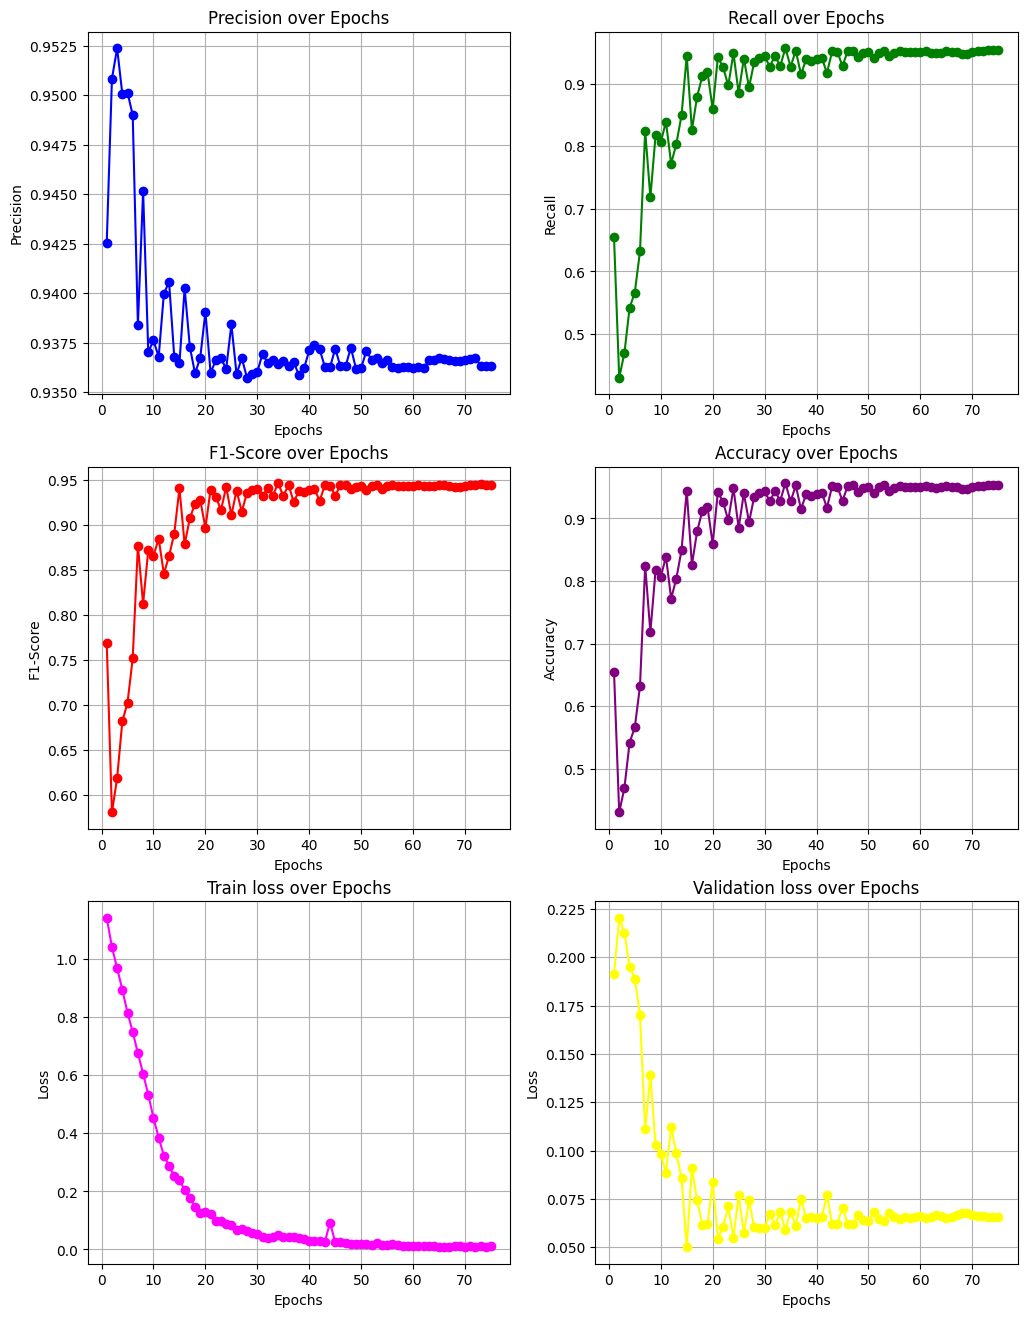

In [17]:
# Plotting the metrics
epochs = range(1, EPOCHS + 1)

# Create subplots
fig, axs = plt.subplots(3, 2, figsize=(12, 16))

# Precision plot
axs[0, 0].plot(epochs, precision_scores, marker='o', color='blue')
axs[0, 0].set_title('Precision over Epochs')
axs[0, 0].set_xlabel('Epochs')
axs[0, 0].set_ylabel('Precision')
axs[0, 0].grid(True)

# Recall plot
axs[0, 1].plot(epochs, recall_scores, marker='o', color='green')
axs[0, 1].set_title('Recall over Epochs')
axs[0, 1].set_xlabel('Epochs')
axs[0, 1].set_ylabel('Recall')
axs[0, 1].grid(True)

# F1-Score plot
axs[1, 0].plot(epochs, f1_scores, marker='o', color='red')
axs[1, 0].set_title('F1-Score over Epochs')
axs[1, 0].set_xlabel('Epochs')
axs[1, 0].set_ylabel('F1-Score')
axs[1, 0].grid(True)

# Accuracy plot
axs[1, 1].plot(epochs, accuracy_scores, marker='o', color='purple')
axs[1, 1].set_title('Accuracy over Epochs')
axs[1, 1].set_xlabel('Epochs')
axs[1, 1].set_ylabel('Accuracy')
axs[1, 1].grid(True)

# Train loss plot
axs[2, 0].plot(epochs, train_loss_per_epoch, marker='o', color='magenta')
axs[2, 0].set_title('Train loss over Epochs')
axs[2, 0].set_xlabel('Epochs')
axs[2, 0].set_ylabel('Loss')
axs[2, 0].grid(True)

# Validation loss plot
axs[2, 1].plot(epochs, val_loss_per_epoch, marker='o', color='yellow')
axs[2, 1].set_title('Validation loss over Epochs')
axs[2, 1].set_xlabel('Epochs')
axs[2, 1].set_ylabel('Loss')
axs[2, 1].grid(True)

# Show all plots
plt.show()

# Creating test dataset

In [18]:
test_labels = torch.tensor(test_tokenized['labels'])
test_input_ids = torch.tensor(test_tokenized['input_ids'])
test_attention_masks = torch.tensor(test_tokenized['attention_mask'])

In [19]:
prediction_data = TensorDataset(test_input_ids, test_attention_masks, test_labels)
prediction_sampler = SequentialSampler(prediction_data)
test_dataloader = DataLoader(prediction_data, sampler=prediction_sampler, batch_size=batch_size)

# Evaluate

In [20]:
model.load_state_dict(torch.load(best_model_path))

model.eval()
test_pred = []
test_true = []

with torch.no_grad():
    for step_num, batch_data in tqdm(enumerate(test_dataloader)):
        input_ids, att_mask, labels = [data.to(device) for data in batch_data]
        output = model(input_ids=input_ids, attention_mask=att_mask, labels=labels)

        logit = output.logits

        test_pred.extend(np.argmax(output.logits.cpu().detach().numpy(), axis=-1))
        test_true.extend(labels.cpu().numpy())

test_pred_flat = np.array(test_pred).flatten()
test_true_flat = np.array(test_true).flatten()

# Calculate evaluation metrics
precision = precision_score(test_true_flat, test_pred_flat, average='weighted', zero_division=0)
recall = recall_score(test_true_flat, test_pred_flat, average='weighted')
f1 = f1_score(test_true_flat, test_pred_flat, average='weighted')
accuracy = accuracy_score(test_true_flat, test_pred_flat)

# Print or use evaluation metrics
print("Precision: ", precision)
print("Recall: ", recall)
print("F1 Score: ", f1)
print("Accuracy: ", accuracy)

0it [00:00, ?it/s]

Precision:  0.7679621862601087
Recall:  0.8673199152542372
F1 Score:  0.813989849512578
Accuracy:  0.8673199152542372


In [29]:
max(test_pred_flat)

2

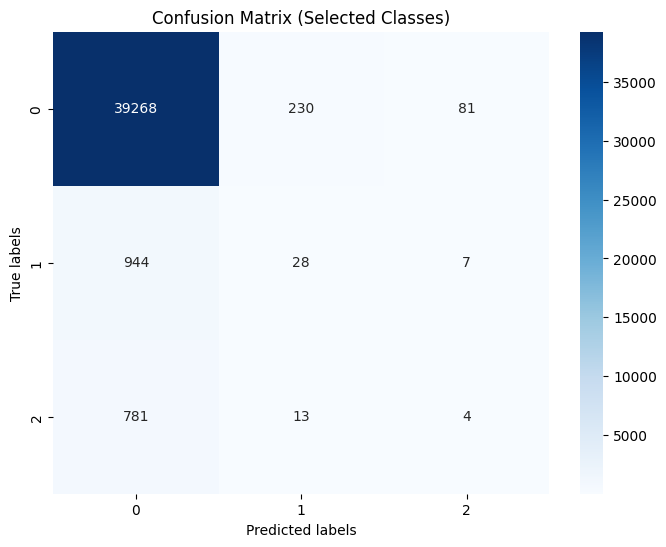

In [36]:
# Compute confusion matrix
conf_matrix = confusion_matrix(test_true_flat, test_pred_flat)

# Mapping actual class labels to display labels
label_mapping = {-100: 0, 0: 1, 1: 2, 2: 3}

# Define the display labels you want to show on the confusion matrix (0, 1, 2)
display_labels = [0, 1, 2]

# Filter and reorganize the confusion matrix based on display labels
filtered_conf_matrix = [[conf_matrix[label_mapping[i]][label_mapping[j]] for j in display_labels] for i in display_labels]

# Plot confusion matrix with selected labels
plt.figure(figsize=(8, 6))
sns.heatmap(filtered_conf_matrix, annot=True, fmt='d', cmap='Blues', xticklabels=display_labels, yticklabels=display_labels)
plt.xlabel('Predicted labels')
plt.ylabel('True labels')
plt.title('Confusion Matrix (Selected Classes)')
plt.show()

# Free RAM

In [ ]:
del precision_scores
del recall_scores
del f1_scores
del accuracy_scores
del model
del scheduler
del optimizer
del train_loss_per_epoch
del val_loss_per_epoch
del class_weight_loss

In [ ]:
torch.cuda.empty_cache()

# Save scores

In [37]:
train_scores = {
    'Metric': ['Precision'] * len(precision_scores) +
              ['Recall'] * len(recall_scores) +
              ['F1'] * len(f1_scores) +
              ['Accuracy'] * len(accuracy_scores) +
              ['Training Loss'] * len(train_loss_per_epoch) +
              ['Validation Loss'] * len(val_loss_per_epoch),

    'Value': precision_scores + recall_scores + f1_scores + accuracy_scores + train_loss_per_epoch + val_loss_per_epoch
}

# Create a DataFrame
train_scores_df = pd.DataFrame(train_scores)

# Save DataFrame to a CSV file
csv_file_path = 'scores_and_losses.csv'
train_scores_df.to_csv(csv_file_path, index=False)

print(f'Scores and losses saved to {csv_file_path}')

Scores and losses saved to scores_and_losses.csv


In [38]:
test_scores = {
    'Metric': ['Precision', 'Recall', 'F1 Score', 'Accuracy'],
    'Value': [precision, recall, f1, accuracy]
}

# Create a DataFrame
test_scores_df = pd.DataFrame(test_scores)

# Save DataFrame to a CSV file
csv_file_path = 'test_results.csv'
test_scores_df.to_csv(csv_file_path, index=False)

print(f'Test scores saved to {csv_file_path}')

Test scores saved to test_results.csv


In [39]:
del train_scores
del train_scores_df
del test_scores
del test_scores_df

# Read Scores and plot data

In [ ]:
# Path to the CSV file containing the scores and losses
csv_file_path = 'scores_and_losses.csv'

# Read the CSV file into a pandas DataFrame
train_scores_df = pd.read_csv(csv_file_path)

# Separate the metrics into different lists
precision_scores = train_scores_df[train_scores_df['Metric'] == 'Precision']['Value'].tolist()
recall_scores = train_scores_df[train_scores_df['Metric'] == 'Recall']['Value'].tolist()
f1_scores = train_scores_df[train_scores_df['Metric'] == 'F1']['Value'].tolist()
accuracy_scores = train_scores_df[train_scores_df['Metric'] == 'Accuracy']['Value'].tolist()
train_loss_per_epoch = train_scores_df[train_scores_df['Metric'] == 'Training Loss']['Value'].tolist()
val_loss_per_epoch = train_scores_df[train_scores_df['Metric'] == 'Validation Loss']['Value'].tolist()

csv_file_path = 'test_results.csv'
test_scores_df = pd.read_csv(csv_file_path)
precision = float(test_scores_df[test_scores_df['Metric'] == 'Precision']['Value'])
recall = float(test_scores_df[test_scores_df['Metric'] == 'Recall']['Value'])
f1 = float(test_scores_df[test_scores_df['Metric'] == 'F1 Score']['Value'])
accuracy = float(test_scores_df[test_scores_df['Metric'] == 'Accuracy']['Value'])

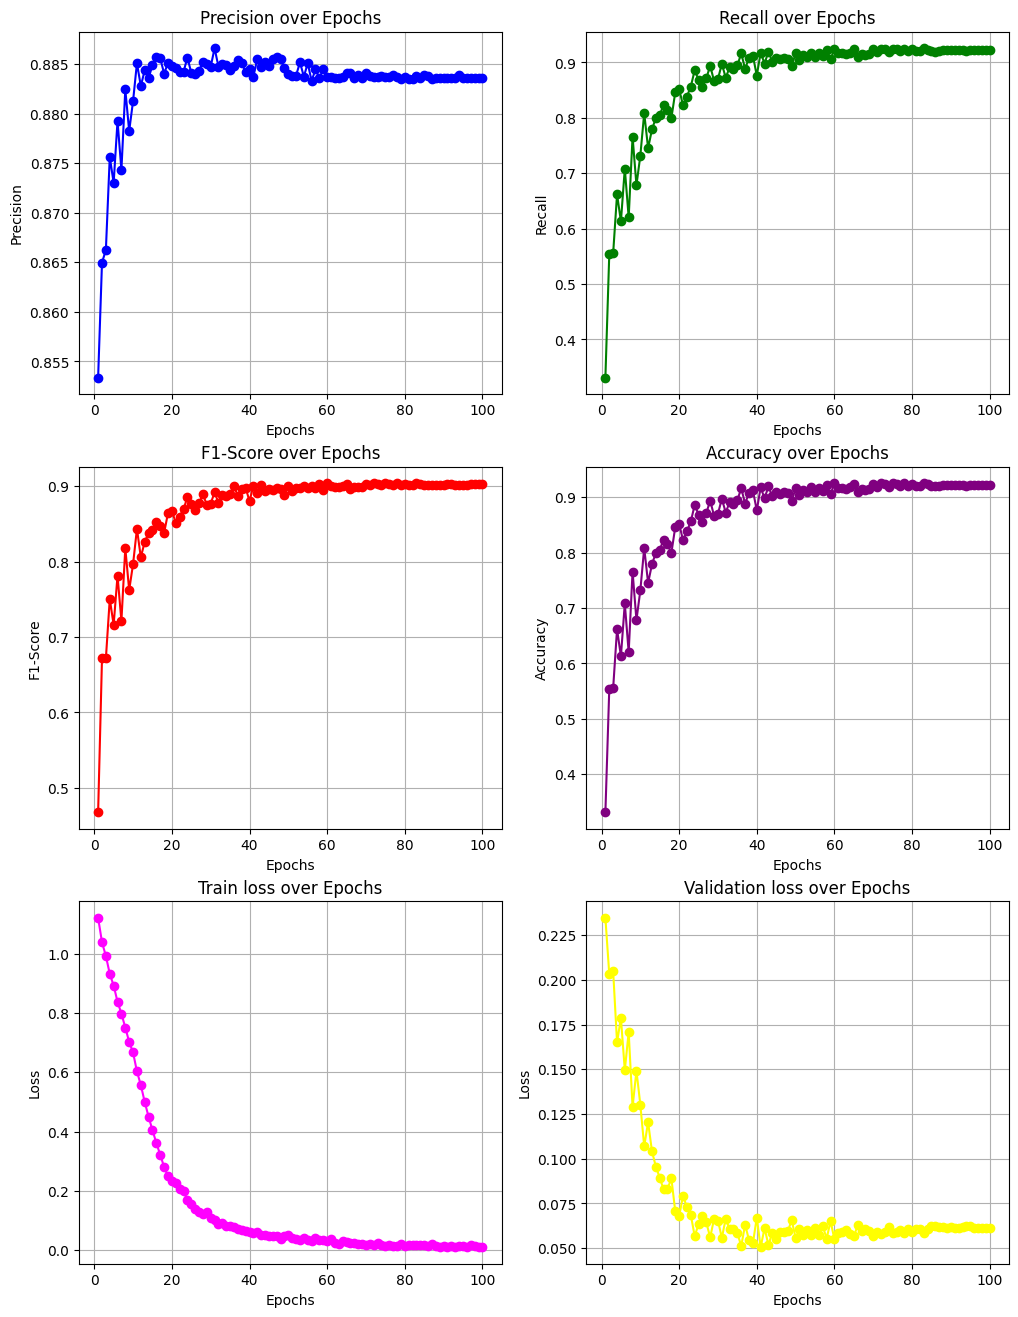

In [ ]:
# Plotting the metrics
epochs = range(1, EPOCHS + 1)

# Create subplots
fig, axs = plt.subplots(3, 2, figsize=(12, 16))

# Precision plot
axs[0, 0].plot(epochs, precision_scores, marker='o', color='blue')
axs[0, 0].set_title('Precision over Epochs')
axs[0, 0].set_xlabel('Epochs')
axs[0, 0].set_ylabel('Precision')
axs[0, 0].grid(True)

# Recall plot
axs[0, 1].plot(epochs, recall_scores, marker='o', color='green')
axs[0, 1].set_title('Recall over Epochs')
axs[0, 1].set_xlabel('Epochs')
axs[0, 1].set_ylabel('Recall')
axs[0, 1].grid(True)

# F1-Score plot
axs[1, 0].plot(epochs, f1_scores, marker='o', color='red')
axs[1, 0].set_title('F1-Score over Epochs')
axs[1, 0].set_xlabel('Epochs')
axs[1, 0].set_ylabel('F1-Score')
axs[1, 0].grid(True)

# Accuracy plot
axs[1, 1].plot(epochs, accuracy_scores, marker='o', color='purple')
axs[1, 1].set_title('Accuracy over Epochs')
axs[1, 1].set_xlabel('Epochs')
axs[1, 1].set_ylabel('Accuracy')
axs[1, 1].grid(True)

# Train loss plot
axs[2, 0].plot(epochs, train_loss_per_epoch, marker='o', color='magenta')
axs[2, 0].set_title('Train loss over Epochs')
axs[2, 0].set_xlabel('Epochs')
axs[2, 0].set_ylabel('Loss')
axs[2, 0].grid(True)

# Validation loss plot
axs[2, 1].plot(epochs, val_loss_per_epoch, marker='o', color='yellow')
axs[2, 1].set_title('Validation loss over Epochs')
axs[2, 1].set_xlabel('Epochs')
axs[2, 1].set_ylabel('Loss')
axs[2, 1].grid(True)

# Show all plots
plt.show()

In [ ]:
print("Precision: ", precision)
print("Recall: ", recall)
print("F1 Score: ", f1)
print("Accuracy: ", accuracy)

Precision:  0.7685820623535459
Recall:  0.8674081920903954
F1 Score:  0.8138002905394909
Accuracy:  0.8674081920903954


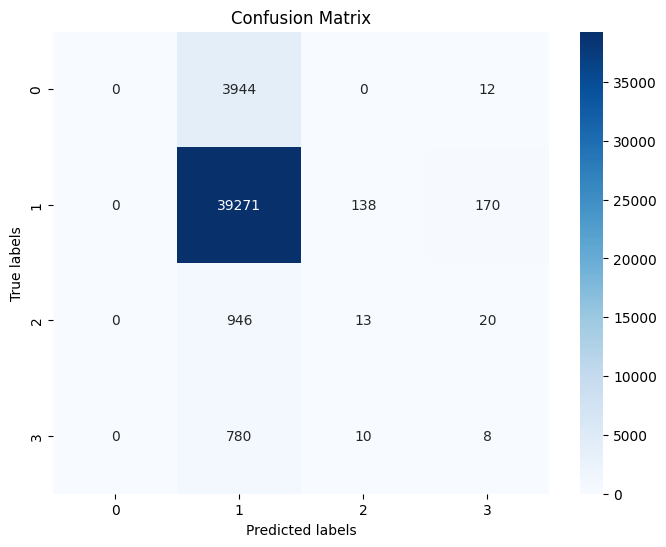

In [ ]:
# Compute confusion matrix
conf_matrix = confusion_matrix(test_true_flat, test_pred_flat)

# Plot confusion matrix
plt.figure(figsize=(8, 6))
sns.heatmap(conf_matrix, annot=True, fmt='d', cmap='Blues')
plt.xlabel('Predicted labels')
plt.ylabel('True labels')
plt.title('Confusion Matrix')
plt.show()